In [1]:
import glob
import itertools
from pathlib import Path

import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord
from gammapy.stats import WStatCountsStatistic
from magicctapipe.io import get_dl2_mean, get_stereo_events
from magicctapipe.utils import calculate_off_coordinates
from matplotlib import pyplot as plt

In [2]:
# Display all the columns of a pandas data frame
pd.set_option("display.max_columns", None)

# Customize the pyplot figure
plt.rcParams.update(
    {"figure.figsize": (12, 9), "font.size": 15, "grid.linestyle": "dotted"}
)

# Get the pyplot default color cycle
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Load an input DL2 data file

In [3]:
# ================
# === Settings ===
# ================

input_file_mask = (
    "/home/yoshiki.ohtani/lstmagic/real/CrabNebula/2020_12_15/"
    "4.dl1_stereo_to_dl2/data/dl2/merged/*Run0326[7-8].h5"
)

# input_file_mask = (
#     "/home/yoshiki.ohtani/lstmagic/real/CrabNebula/2020_12_15/magic_only_analysis/"
#     "4.dl1_stereo_to_dl2/data/dl2/merged/dl2_MAGIC.Run0509371[3-4].h5"
# )

quality_cuts = f"(disp_diff_mean < {np.sqrt(0.05)})"

# ============
# === Main ===
# ============

# Find the input files
input_files = glob.glob(input_file_mask)
input_files.sort()

print("The following files are found:")

data_list = []

for input_file in input_files:

    print(Path(input_file).name)

    # Load the input file
    df_events = pd.read_hdf(input_file, key="events/parameters")
    data_list.append(df_events)

# Combine the input data
event_data = pd.concat(data_list)
event_data.set_index(["obs_id", "event_id", "tel_id"], inplace=True)
event_data.sort_index(inplace=True)

# Apply the quality cuts
print(f"\nQuality cuts:\n{quality_cuts}")
event_data = get_stereo_events(event_data, quality_cuts)

# Show the data frame
event_data.head()

The following files are found:
dl2_LST-1_MAGIC.Run03267.h5
dl2_LST-1_MAGIC.Run03268.h5

Quality cuts:
(disp_diff_mean < 0.22360679774997896)



In total 27811 stereo events are found:
	m1_m2 (type 0): 189 events (0.7%)
	lst1_m1 (type 1): 2828 events (10.2%)
	lst1_m2 (type 2): 7291 events (26.2%)
	lst1_m1_m2 (type 3): 17503 events (62.9%)


obs_id_magic  event_id_magic   intensity         x  \
obs_id event_id tel_id                                                       
3267   457      1            5093713           17714  185.540064 -0.525367   
                3            5093713           17714  101.493815 -0.216671   
       579      1            5093713           17721  286.816310  0.011477   
                3            5093713           17721  116.296875  0.171340   
       816      1            5093713           17734  465.649789  0.304287   

                               y         r         phi    length  \
obs_id event_id tel_id                                             
3267   457      1       0.091963  0.533355  170.071273  0.032908   
                3       0.210579  0.302142  135.816937  0.032815   
       579      1       0.013702  0.017873   50.051222  0.060872   
                3      -0.053691  0.179555  -17.398986  0.021329   
       816      1       0.427285  0.524560   54.543760  0.386204   

                        length_uncertainty     width  width_uncertainty  \
obs_id event_id tel_id                                                    
3267   457      1                 0.003030  0.026746           0.003138   
                3                 0.001951  0.013266           0.001099   
       579      1                 0.004719  0.024676           0.001602   
                3                 0.001259  0.017540           0.001363   
       816      1                 0.022117  0.088352           0.004918   

                              psi  skewness  kurtosis      slope  intercept  \
obs_id event_id tel_id                                                        
3267   457      1       -0.559540 -0.806885  2.502976   2.381196  15.687231   
                3      -46.782215 -0.395875  2.435489  -0.001229  14.400709   
       579      1      -62.683907 -0.453259  2.646632  -7.284469  16.196574   
                3       73.217978 -0.044091  2.620746  15.589447  15.491371   
       816      1       41.161894 -0.766296  2.458807 -11.366683  19.920776   

                        intensity_width_1  intensity_width_2  pixels_width_1  \
obs_id event_id tel_id                                                         
3267   457      1                     0.0                0.0             0.0   
                3                     0.0                0.0             0.0   
       579      1                     0.0                0.0             0.0   
                3                     0.0                0.0             0.0   
       816      1                     0.0                0.0             0.0   

                        pixels_width_2  n_pixels  n_islands  pointing_alt  \
obs_id event_id tel_id                                                      
3267   457      1                  0.0         8          1      0.821505   
                3                  0.0        10          1      0.821369   
       579      1                  0.0        12          1      0.821508   
                3                  0.0         9          1      0.821371   
       816      1                  0.0        38          3      0.821516   

                        pointing_az     timestamp  time_diff  multiplicity  \
obs_id event_id tel_id                                                       
3267   457      1          1.526396  1.608070e+09   0.000108             2   
                3          1.526365  1.608070e+09   0.001145             2   
       579      1          1.526398  1.608070e+09   0.000209             2   
                3          1.526366  1.608070e+09   0.001351             2   
       816      1          1.526402  1.608070e+09   0.000015             2   

                        combo_type        alt  alt_uncert         az  \
obs_id event_id tel_id                                                 
3267   457      1              2.0  46.831287    0.000000  87.719151   
                3              2.0  46.831287    0.00000

In [4]:
# Get the mean DL2 parameters
print("Calculating the mean DL2 parameters...")
event_data_mean = get_dl2_mean(event_data)

# Show the data frame
event_data_mean.head()

Calculating the mean DL2 parameters...


combo_type  multiplicity     timestamp  pointing_alt  \
obs_id event_id                                                         
3267   457              2.0           2.0  1.608070e+09      0.821437   
       579              2.0           2.0  1.608070e+09      0.821440   
       816              1.0           2.0  1.608070e+09      0.821458   
       860              3.0           3.0  1.608070e+09      0.821431   
       1016             3.0           3.0  1.608070e+09      0.821434   

                 pointing_az  reco_energy   reco_alt    reco_az  gammaness  \
obs_id event_id                                                              
3267   457          1.526381     0.129872  46.882598  87.682477   0.012976   
       579          1.526382     0.097652  47.409783  86.522547   0.392292   
       816          1.526397     0.373710  47.066803  88.078692   0.016250   
       860          1.526388     0.250485  48.339574  84.829078   0.331611   
       1016         1.526389     0.150781  45.946746  86.549841   0.607060   

                 pointing_ra  pointing_dec    reco_ra   reco_dec  
obs_id event_id                                                   
3267   457         83.966218     22.246434  84.098356  22.040767  
       579         83.966156     22.246429  83.827949  22.956083  
       816         83.965086     22.246235  83.815853  21.845343  
       860         83.966841     22.246069  83.226823  24.316628  
       1016        83.966795     22.246066  85.327824  22.478844

In [5]:
# Calculate the observation time
time_diffs = np.diff(event_data_mean["timestamp"])
obs_time = time_diffs[time_diffs < 1].sum() * u.s

print(f"Observation time: {obs_time.to_value(u.min).round(1)} [min]")

Observation time: 26.5 [min]


# Calculate the angular distances from ON and OFF regions

ON coordinate (Crab):
<SkyCoord (ICRS): (ra, dec) in deg
    (83.63308333, 22.0145)>

Number of OFF regions: 3

Observation ID: 3267

OFF coordinates:
<SkyCoord (ICRS): (ra, dec) in deg
    (84.30477545, 22.47762281)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.71753602, 22.55646019)>
<SkyCoord (ICRS): (ra, dec) in deg
    (84.21865324, 21.93528265)>


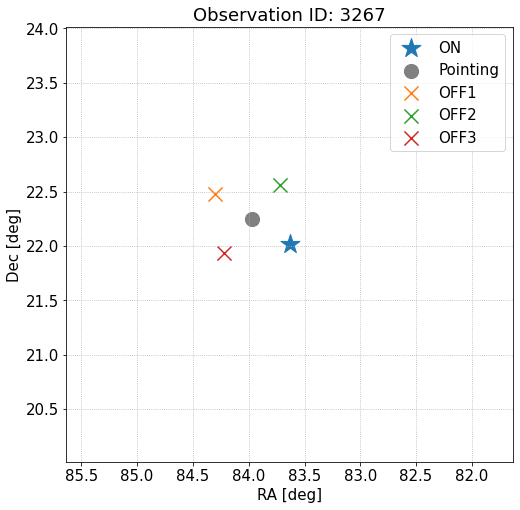


Observation ID: 3268

OFF coordinates:
<SkyCoord (ICRS): (ra, dec) in deg
    (82.90139405, 21.562441)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.50936419, 21.44831613)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.02338687, 22.12826509)>


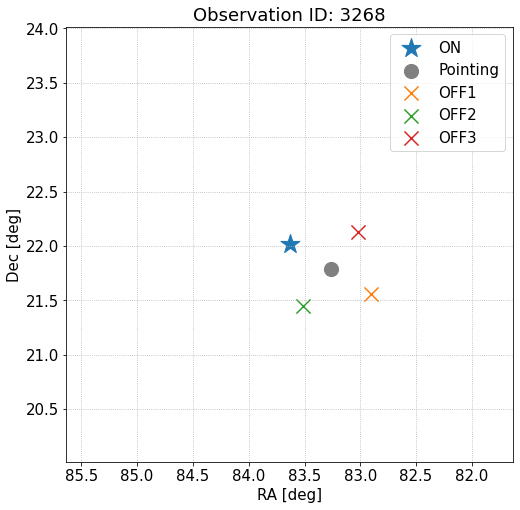

combo_type  multiplicity     timestamp  pointing_alt  \
obs_id event_id                                                         
3267   457              2.0           2.0  1.608070e+09      0.821437   
       579              2.0           2.0  1.608070e+09      0.821440   
       816              1.0           2.0  1.608070e+09      0.821458   
       860              3.0           3.0  1.608070e+09      0.821431   
       1016             3.0           3.0  1.608070e+09      0.821434   

                 pointing_az  reco_energy   reco_alt    reco_az  gammaness  \
obs_id event_id                                                              
3267   457          1.526381     0.129872  46.882598  87.682477   0.012976   
       579          1.526382     0.097652  47.409783  86.522547   0.392292   
       816          1.526397     0.373710  47.066803  88.078692   0.016250   
       860          1.526388     0.250485  48.339574  84.829078   0.331611   
       1016         1.526389     0.150781  45.946746  86.549841   0.607060   

                 pointing_ra  pointing_dec    reco_ra   reco_dec  theta2_on  \
obs_id event_id                                                               
3267   457         83.966218     22.246434  84.098356  22.040767   0.186718   
       579         83.966156     22.246429  83.827949  22.956083   0.918996   
       816         83.965086     22.246235  83.815853  21.845343   0.057360   
       860         83.966841     22.246069  83.226823  24.316628   5.439271   
       1016        83.966795     22.246066  85.327824  22.478844   2.676039   

                 theta2_off1  theta2_off2  theta2_off3  
obs_id event_id                                         
3267   457          0.227338     0.390083     0.023570  
       579          0.422378     0.170065     1.172425  
       816          0.604805     0.513974     0.147784  
       860          4.360554     3.300874     6.502601  
       1016         0.893632     2.218725     1.349959

In [6]:
# ================
# === Settings ===
# ================

source_name = "Crab"
n_off_regions = 3

# ============
# === Main ===
# ============

on_coord = SkyCoord.from_name(source_name, frame="icrs")
print(f"ON coordinate ({source_name}):\n{on_coord}")

xlim = [on_coord.ra.value + 2, on_coord.ra.value - 2]
ylim = [on_coord.dec.value - 2, on_coord.dec.value + 2]

print(f"\nNumber of OFF regions: {n_off_regions}")

# Loop over every observation ID
obs_ids = np.unique(event_data_mean.index.get_level_values("obs_id"))

for obs_id in obs_ids:

    print(f"\nObservation ID: {obs_id}")
    df_events = event_data_mean.query(f"obs_id == {obs_id}")

    reco_ra = df_events["reco_ra"].to_numpy() * u.deg
    reco_dec = df_events["reco_dec"].to_numpy() * u.deg
    pointing_ra = df_events["pointing_ra"].mean() * u.deg
    pointing_dec = df_events["pointing_dec"].mean() * u.deg

    event_coords = SkyCoord(reco_ra, reco_dec, frame="icrs")

    # Calculate the angular distances from the ON region
    theta_on = on_coord.separation(event_coords)
    theta2_on = theta_on.to(u.deg) ** 2

    index = (obs_id, slice(None))
    event_data_mean.loc[index, "theta2_on"] = theta2_on.value

    # Calculate the OFF coordinates
    off_coords = calculate_off_coordinates(
        pointing_ra=pointing_ra,
        pointing_dec=pointing_dec,
        on_coord_ra=on_coord.ra,
        on_coord_dec=on_coord.dec,
        n_off_regions=n_off_regions,
    )

    # Create a figure
    plt.figure(figsize=(8, 8))
    plt.title(f"Observation ID: {obs_id}")
    plt.xlabel("RA [deg]")
    plt.ylabel("Dec [deg]")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.axis(xlim + ylim)
    plt.grid()

    # Plot the ON coordinate
    plt.scatter(on_coord.ra.value, on_coord.dec.value, label="ON", marker="*", s=400)

    # Plot the pointing direction
    plt.scatter(
        pointing_ra.value,
        pointing_dec.value,
        label="Pointing",
        marker="o",
        s=200,
        color="grey",
    )

    print("\nOFF coordinates:")

    for i_off, off_coord in off_coords.items():

        print(off_coord)

        # Calculate the angular distance from the OFF coordinate
        theta_off = off_coord.separation(event_coords)
        theta2_off = theta_off.to(u.deg) ** 2

        event_data_mean.loc[index, f"theta2_off{i_off}"] = theta2_off.value

        # Plot the OFF coordinate
        plt.scatter(
            off_coord.ra.value,
            off_coord.dec.value,
            label=f"OFF{i_off}",
            marker="x",
            s=200,
            color=colors[i_off],
        )

    plt.legend()
    plt.show()

# Show the data frame
event_data_mean.head()

# Check a signal from the source

In [7]:
# ================
# === Settings ===
# ================

combo_types = [3]
gh_cut_value = 0.8

# ============
# === Main ===
# ============

print(f"Combination types: {combo_types}" f"\nGlobal gammaness cut: {gh_cut_value}")

# Get the event list
event_list = event_data_mean.query(
    f"(combo_type == {combo_types}) & (gammaness > {gh_cut_value})"
).copy()

print(f"--> Number of events: {len(event_list)}")

# Show the event list
event_list.head()

Combination types: [3]
Global gammaness cut: 0.8
--> Number of events: 4169


combo_type  multiplicity     timestamp  pointing_alt  \
obs_id event_id                                                         
3267   1154             3.0           3.0  1.608070e+09      0.821436   
       4335             3.0           3.0  1.608070e+09      0.821490   
       4713             3.0           3.0  1.608070e+09      0.821496   
       7155             3.0           3.0  1.608070e+09      0.821538   
       10193            3.0           3.0  1.608070e+09      0.821567   

                 pointing_az  reco_energy   reco_alt    reco_az  gammaness  \
obs_id event_id                                                              
3267   1154         1.526390     0.215995  46.880783  89.535278   0.882333   
       4335         1.526419     0.555865  47.640275  87.849001   0.877881   
       4713         1.526422     0.244638  47.157871  87.654190   0.965250   
       7155         1.526445     0.351270  47.381234  85.156784   0.838611   
       10193        1.526460     0.135433  46.660539  88.346123   0.824111   

                 pointing_ra  pointing_dec    reco_ra   reco_dec  theta2_on  \
obs_id event_id                                                               
3267   1154        83.966751     22.246063  83.645539  20.846786   1.363691   
       4335        83.965766     22.245997  83.288218  22.178814   0.129102   
       4713        83.965658     22.245990  83.827486  22.148160   0.050317   
       7155        83.964898     22.245939  84.166962  23.828890   3.533771   
       10193       83.965328     22.245917  84.170912  21.538492   0.476030   

                 theta2_off1  theta2_off2  theta2_off3  
obs_id event_id                                         
3267   1154         3.034968     2.927462     1.469579  
       4335         0.973518     0.300238     0.802929  
       4713         0.303513     0.177049     0.176779  
       7155         1.841978     1.789723     3.588016  
       10193        0.897369     1.212839     0.159409

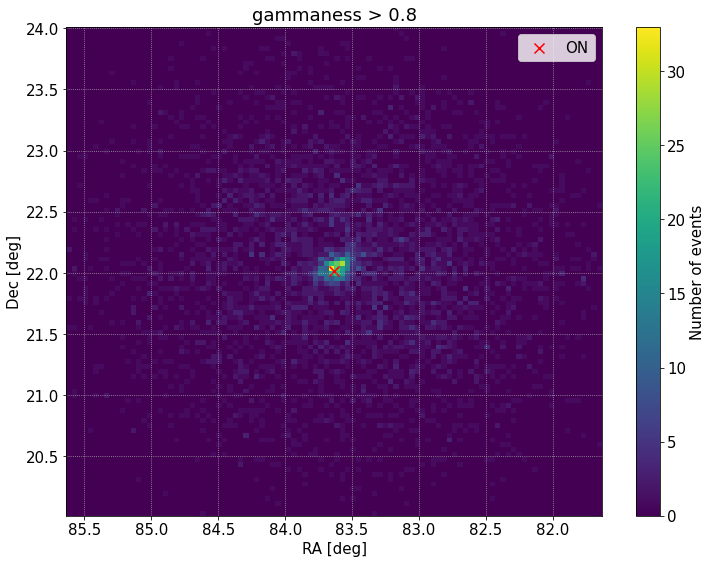

In [8]:
plt.figure()
plt.title(f"gammaness > {gh_cut_value}")
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.xlim(xlim)
plt.ylim(ylim)

# Plot the count map
plt.hist2d(
    event_list["reco_ra"].to_numpy(),
    event_list["reco_dec"].to_numpy(),
    bins=[np.linspace(xlim[1], xlim[0], 101), np.linspace(ylim[0], ylim[1], 101)],
)

plt.colorbar(label="Number of events")
plt.axis(xlim + ylim)
plt.grid()

# Plot the ON coordinate
plt.scatter(
    on_coord.ra.value, on_coord.dec.value, marker="x", s=100, color="red", label="ON"
)

plt.legend()

Global theta2 cut: 0.04 [deg2]

Non: 632

Noff1: 147
Noff2: 142
Noff3: 126
--> Total Noff: 415

alpha = 0.333
--> Scaled Noff: 138

Nexcess: 494
Observation time: 26.54 [min]
--> Excess rate: 18.60 [1/min]

Li&Ma significance: 24.2 sigma


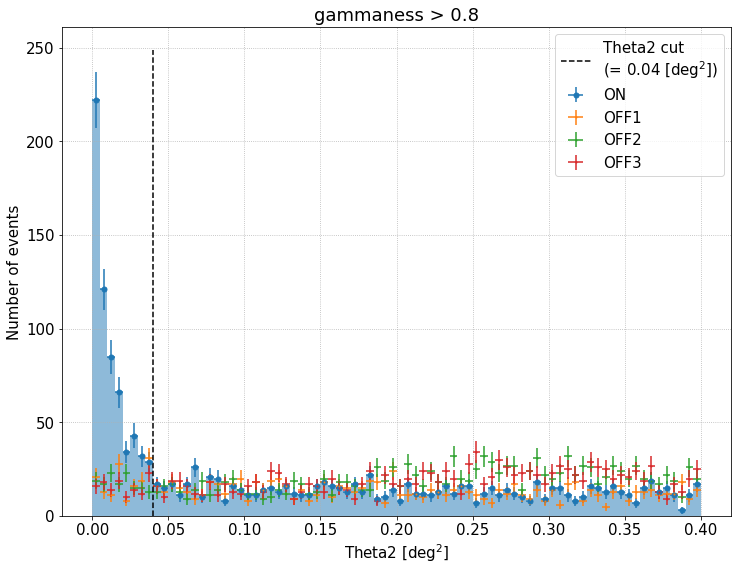

In [9]:
# ================
# === Settings ===
# ================

theta2_bins = np.linspace(0, 0.4, 81)
theta2_cut_value = 0.04  # unit: [deg2]

# ============
# === Main ===
# ============

theta2_bins_center = (theta2_bins[:-1] + theta2_bins[1:]) / 2

theta2_bins_width = [
    theta2_bins_center - theta2_bins[:-1],
    theta2_bins[1:] - theta2_bins_center,
]

plt.figure()
plt.title(f"gammaness > {gh_cut_value}")
plt.xlabel("Theta2 [deg$^2$]")
plt.ylabel("Number of events")
plt.grid()

# Plot the theta2 distribution from the ON coordinate
hist_on = plt.hist(
    event_list["theta2_on"].to_numpy(),
    bins=theta2_bins,
    histtype="bar",
    linewidth=2,
    alpha=0.5,
)[0]

plt.errorbar(
    x=theta2_bins_center,
    y=hist_on,
    xerr=theta2_bins_width,
    yerr=np.sqrt(hist_on),
    fmt="o",
    markersize=5,
    label="ON",
    color=colors[0],
)

# Plot the theta2 distrubutions from the OFF coordinates
for i_off in range(n_off_regions):

    hist_off, _ = np.histogram(
        event_list[f"theta2_off{i_off+1}"].to_numpy(), bins=theta2_bins
    )

    plt.errorbar(
        x=theta2_bins_center,
        y=hist_off,
        xerr=theta2_bins_width,
        yerr=np.sqrt(hist_off),
        fmt="o",
        markersize=1,
        label=f"OFF{i_off+1}",
    )

# Plot the theta2 cut
print(f"Global theta2 cut: {theta2_cut_value} [deg2]")

plt.plot(
    (theta2_cut_value, theta2_cut_value),
    (0, plt.ylim()[1]),
    linestyle="--",
    color="black",
    label=f"Theta2 cut\n(= {theta2_cut_value} [deg$^2$])",
)

plt.legend(loc="upper right")

# Calculate the number of ON and OFF events
n_on = len(event_list.query(f"theta2_on < {theta2_cut_value}"))
print(f"\nNon: {n_on}\n")

n_off_total = 0

for i_off in range(1, n_off_regions + 1):

    n_off = len(event_list.query(f"theta2_off{i_off} < {theta2_cut_value}"))
    print(f"Noff{i_off}: {n_off}")

    n_off_total += n_off

print(f"--> Total Noff: {n_off_total}")

alpha = 1 / n_off_regions
n_off_scaled = n_off_total * alpha

print(f"\nalpha = {alpha:.3f}" f"\n--> Scaled Noff: {n_off_scaled:.0f}")

n_excess = n_on - n_off_scaled
excess_rate = n_excess / obs_time.to(u.min)

print(
    f"\nNexcess: {n_excess:.0f}"
    f"\nObservation time: {obs_time.to_value(u.min):.2f} [min]"
    f"\n--> Excess rate: {excess_rate.value:.2f} [1/min]"
)

# Calculate the Li&Ma significance
stat = WStatCountsStatistic(n_on, n_off_total, alpha=alpha)
significance = stat.sqrt_ts

print(f"\nLi&Ma significance: {significance:.1f} sigma")

### Check the theta2 distributions with different energy bins:

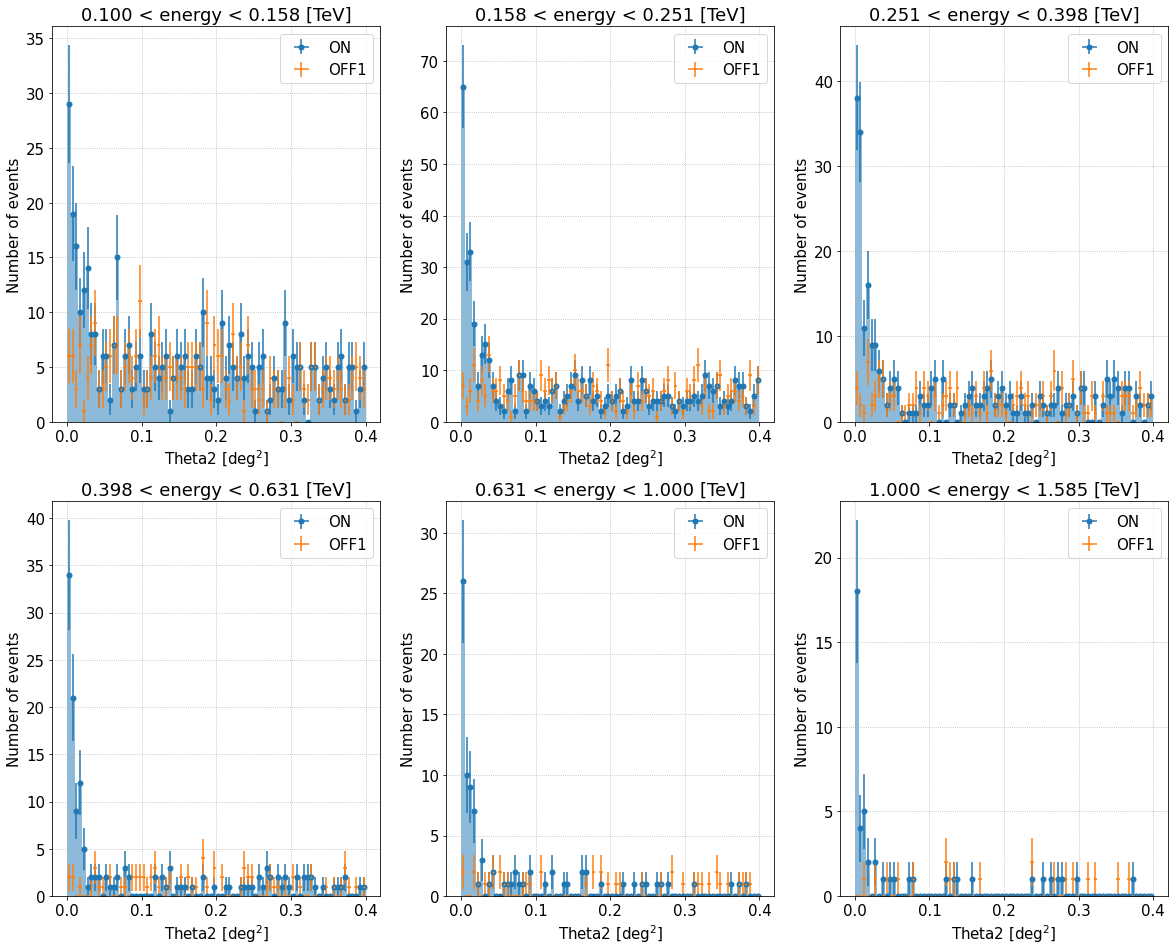

In [10]:
# ================
# === Settings ===
# ================

energy_bins = np.logspace(-1, 1, 11)[:-4]

# ============
# === Main ===
# ============

n_columns = 3
n_rows = int(np.ceil(len(energy_bins[:-1]) / n_columns))

grid = (n_rows, n_columns)
locs = list(itertools.product(range(n_rows), range(n_columns)))

plt.figure(figsize=(20, n_rows * 8))

# Loop over every energy bin
for i_bin, (eng_lo, eng_hi) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):

    plt.subplot2grid(grid, locs[i_bin])
    plt.title(f"{eng_lo:.3f} < energy < {eng_hi:.3f} [TeV]")
    plt.xlabel("Theta2 [deg$^2$]")
    plt.ylabel("Number of events")
    plt.grid()

    # Apply the energy cut
    df_events = event_list.query(
        f"(reco_energy > {eng_lo}) & (reco_energy < {eng_hi})"
    ).copy()

    if len(df_events) > 0:

        # Plot the theta2 distribution from the ON coordinate
        hist_on = plt.hist(
            df_events["theta2_on"].to_numpy(),
            bins=theta2_bins,
            histtype="bar",
            linewidth=2,
            alpha=0.5,
        )[0]

        plt.errorbar(
            x=theta2_bins_center,
            y=hist_on,
            xerr=theta2_bins_width,
            yerr=np.sqrt(hist_on),
            fmt="o",
            markersize=5,
            label="ON",
            color=colors[0],
        )

        # Plot the theta2 distribution from the OFF1 coordinate
        hist_off, _ = np.histogram(
            df_events["theta2_off1"].to_numpy(), bins=theta2_bins
        )

        plt.errorbar(
            x=theta2_bins_center,
            y=hist_off,
            xerr=theta2_bins_width,
            yerr=np.sqrt(hist_off),
            fmt="o",
            markersize=1,
            label=f"OFF1",
        )

        plt.legend(loc="upper right")